In [12]:
pip install nexradaws

  Using cached nexradaws-1.1-py2.py3-none-any.whl (9.2 kB)
Note: you may need to restart the kernel to use updated packages.


In [17]:
conda install -c conda-forge arm_pyart

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\snoda\anaconda3

  added / updated specs:
    - arm_pyart


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arm_pyart-1.11.5           |   py38hcb5f9af_0         7.6 MB  conda-forge
    cftime-1.5.0               |   py38hcb5f9af_0         158 KB  conda-forge
    hdf4-4.2.13                |       h712560f_2         1.3 MB
    libnetcdf-4.7.3            |       h1302dcc_0         516 KB
    netcdf4-1.5.3              |   py38h012c1a0_0         374 KB
    xarray-0.18.2              |     pyhd8ed1ab_0         599 KB  conda-forge
    ------------------------------------------------

In [1]:
import nexradaws
import pytz
import boto3
from datetime import datetime
from botocore import UNSIGNED
from botocore.client import Config
import pyart
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
conn = nexradaws.NexradAwsInterface()

C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Print available years

print(conn.get_avail_years())

C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [4]:
# Get available radars on a given day

print(conn.get_avail_radars('2021', '06', '29'))

C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['FOP1', 'KABR', 'KABX', 'KAKQ', 'KAMA', 'KAMX', 'KAPX', 'KARX', 'KATX', 'KBBX', 'KBGM', 'KBHX', 'KBIS', 'KBLX', 'KBMX', 'KBOX', 'KBRO', 'KBUF', 'KBYX', 'KCAE', 'KCBW', 'KCBX', 'KCCX', 'KCLE', 'KCLX', 'KCRP', 'KCXX', 'KCYS', 'KDAX', 'KDDC', 'KDFX', 'KDGX', 'KDIX', 'KDLH', 'KDMX', 'KDOX', 'KDTX', 'KDVN', 'KDYX', 'KEAX', 'KEMX', 'KENX', 'KEOX', 'KEPZ', 'KESX', 'KEVX', 'KEWX', 'KEYX', 'KFCX', 'KFDR', 'KFDX', 'KFFC', 'KFSD', 'KFSX', 'KFTG', 'KFWS', 'KGGW', 'KGJX', 'KGLD', 'KGRB', 'KGRK', 'KGRR', 'KGSP', 'KGWX', 'KGYX', 'KHDX', 'KHGX', 'KHPX', 'KHTX', 'KICT', 'KICX', 'KILN', 'KILX', 'KIND', 'KINX', 'KIWA', 'KIWX', 'KJAX', 'KJGX', 'KJKL', 'KLBB', 'KLCH', 'KLGX', 'KLIX', 'KLNX', 'KLOT', 'KLRX', 'KLSX', 'KLTX', 'KLVX', 'KLWX', 'KLZK', 'KMAF', 'KMAX', 'KMBX', 'KMHX', 'KMKX', 'KMLB', 'KMOB', 'KMPX', 'KMQT', 'KMRX', 'KMSX', 'KMTX', 'KMUX', 'KMVX', 'KMXX', 'KNKX', 'KNQA', 'KOAX', 'KOHX', 'KOKX', 'KOTX', 'KPAH', 'KPBZ', 'KPDT', 'KPUX', 'KRAX', 'KRGX', 'KRIW', 'KRLX', 'KRTX', 'KSFX', 'KSGF', 'KSHV',

In [5]:
# San Diego radar station is KNKX
# Check how many San Diego scans are available between 8am June 15, 2021 and 12pm June 28, 2021
# NOTE: The scanner times out if date ranges are too big. 15 days seems to be the limit

pacific_timezone = pytz.timezone('US/Pacific')
radar_id = 'KNKX'
start = pacific_timezone.localize(datetime(2021, 6, 15, 8, 0))
end = pacific_timezone.localize(datetime(2021, 6, 28, 12, 0))
scans = conn.get_avail_scans_in_range(start, end, radar_id)
print(f'There are {len(scans)} between {start} and {end}')

C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are 3703 between 2021-06-15 08:00:00-07:00 and 2021-06-28 12:00:00-07:00


In [15]:
# Download the first 4 results

results = conn.download(scans[8:12], 'c:')

C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Downloaded KNKX20210615_213731_V06
Downloaded KNKX20210615_211810_V06
Downloaded KNKX20210615_214711_V06
Downloaded KNKX20210615_212751_V06
4 out of 4 files downloaded...0 errors


In [25]:
for scan in results.iter_success():
    print ("{} volume scan time {}".format(scan.radar_id,scan.scan_time))

KNKX volume scan time 2021-06-15 21:18:10+00:00
KNKX volume scan time 2021-06-15 21:27:51+00:00
KNKX volume scan time 2021-06-15 21:37:31+00:00
KNKX volume scan time 2021-06-15 21:47:11+00:00


C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


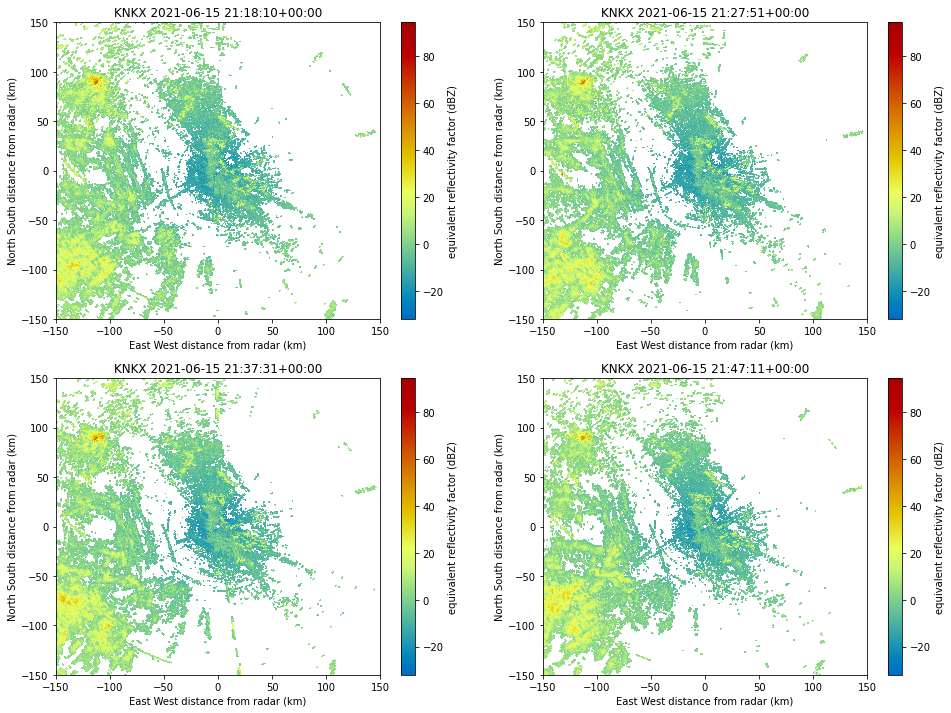

In [26]:
# Plotting the 4 results we received above

fig = plt.figure(figsize=(16, 12))
for i, scan in enumerate(results.iter_success(), start=1):
    ax = fig.add_subplot(2, 2, i)
    radar = scan.open_pyart()
    display = pyart.graph.RadarDisplay(radar)
    display.plot('reflectivity', 0, ax=ax, title="{} {}".format(scan.radar_id, scan.scan_time))
    display.set_limits((-150, 150), (-150, 150), ax=ax)

In [35]:
# Basic calls to check bucket

import six
import nexradaws
conn = nexradaws.NexradAwsInterface()
six.print_(conn.get_avail_years())
six.print_(conn.get_avail_months('2013'))
six.print_(conn.get_avail_days('2013', '05'))
six.print_(conn.get_avail_radars('2013', '05', '31'))
six.print_(conn.get_avail_scans('2013', '05', '31', 'KTLX'))

C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
['DAN1', 'KABR', 'KABX', 'KAKQ', 'KAMA', 'KAMX', 'KAPX', 'KARX', 'KATX', 'KBBX', 'KBGM', 'KBHX', 'KBIS', 'KBLX', 'KBMX', 'KBOX', 'KBRO', 'KBUF', 'KBYX', 'KCAE', 'KCBW', 'KCBX', 'KCCX', 'KCLE', 'KCLX', 'KCRP', 'KCXX', 'KCYS', 'KDAX', 'KDDC', 'KDFX', 'KDGX', 'KDLH', 'KDMX', 'KDOX', 'KDTX', 'KDVN', 'KEAX', 'KEMX', 'KENX', 'KEOX', 'KEPZ', 'KESX', 'KEVX', 'KEWX', 'KEYX', 'KFCX', 'KFDR', 'KFFC', 'KFSD', 'KFSX', 'KFTG', 'KFWS', 'KGGW', 'KGJX', 'KGLD', 'KGRB', 'KGRK', 'KGRR', 'KGSP', 'KGWX', 'K

In [29]:
# The previous steps were conducted using NEXRADAWS
# These following steps will be conducted using boto3 client

import boto3
import botocore
from botocore.client import Config
import matplotlib.pyplot as plt
from metpy.io import Level2File
from metpy.plots import add_timestamp, ctables
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Let's look into a current tropical storm that is hitting the east coast: Tropical Storm Danny
# Charleston, SC Radar Station KCLX
# Date: 6/28/2021

s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED,
                                        user_agent_extra='Resource'))
bucket = s3.Bucket('noaa-nexrad-level2')
for obj in bucket.objects.filter(Prefix='2021/06/29/KCLX/KCLX20210629_001716'):
    print(obj.key)

    # Use MetPy to read the file
    f = Level2File(obj.get()['Body'])

C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021/06/29/KCLX/KCLX20210629_001716_V06


In [31]:
# With the file comes a lot of data, including multiple elevations and products. Here, we'll pull out the specific data we want to plot.

sweep = 0
# First item in ray is header, which has azimuth angle
az = np.array([ray[0].az_angle for ray in f.sweeps[sweep]])

ref_hdr = f.sweeps[sweep][0][4][b'REF'][0]
ref_range = np.arange(ref_hdr.num_gates) * ref_hdr.gate_width + ref_hdr.first_gate
ref = np.array([ray[4][b'REF'][1] for ray in f.sweeps[sweep]])

rho_hdr = f.sweeps[sweep][0][4][b'RHO'][0]
rho_range = (np.arange(rho_hdr.num_gates + 1) - 0.5) * rho_hdr.gate_width + rho_hdr.first_gate
rho = np.array([ray[4][b'RHO'][1] for ray in f.sweeps[sweep]])

phi_hdr = f.sweeps[sweep][0][4][b'PHI'][0]
phi_range = (np.arange(phi_hdr.num_gates + 1) - 0.5) * phi_hdr.gate_width + phi_hdr.first_gate
phi = np.array([ray[4][b'PHI'][1] for ray in f.sweeps[sweep]])

zdr_hdr = f.sweeps[sweep][0][4][b'ZDR'][0]
zdr_range = (np.arange(zdr_hdr.num_gates + 1) - 0.5) * zdr_hdr.gate_width + zdr_hdr.first_gate
zdr = np.array([ray[4][b'ZDR'][1] for ray in f.sweeps[sweep]])

C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\snoda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-32-d7152d2fa960>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  a = ax.pcolormesh(xlocs, ylocs, data, cmap=colors, norm=norm)


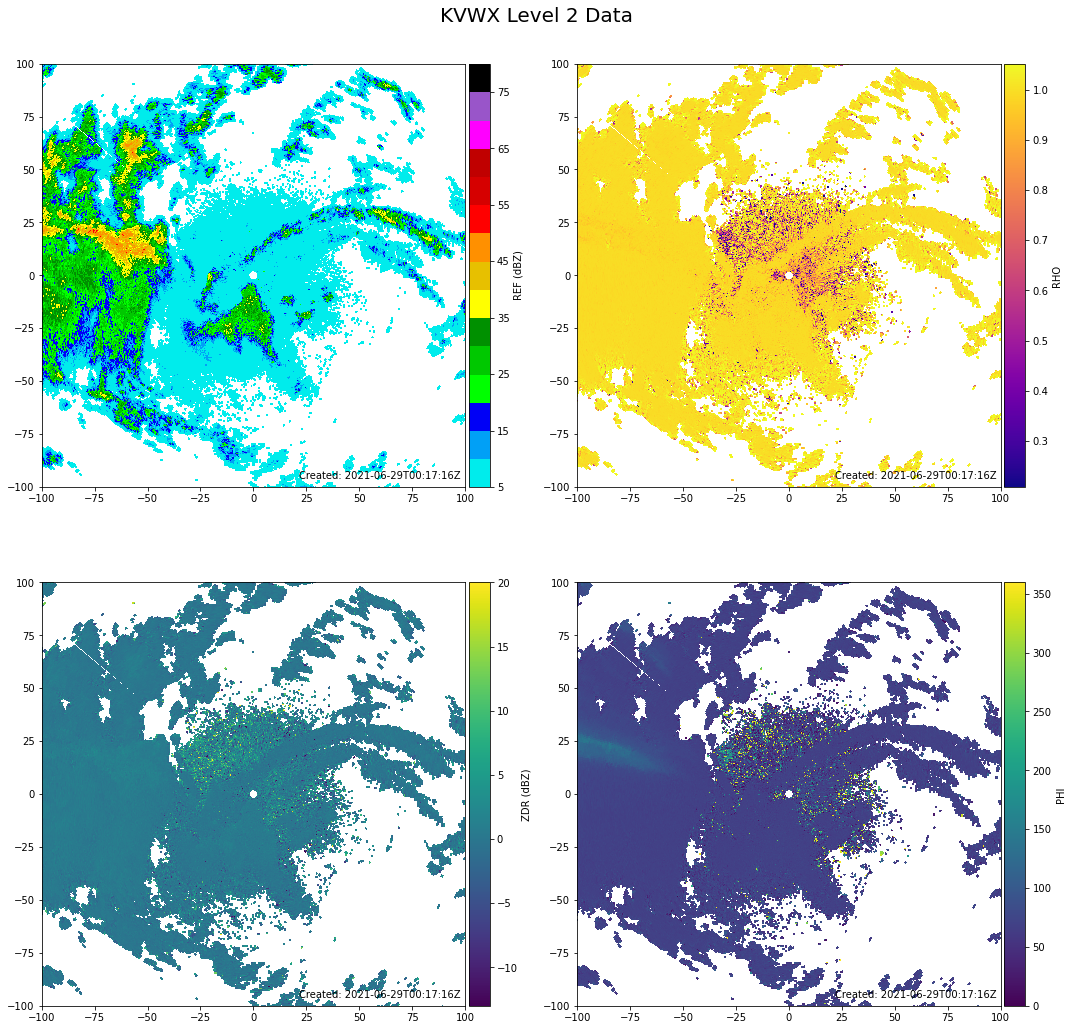

In [32]:
# Now we plot the data
# Get the NWS reflectivity colortable from MetPy
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

# Plot the data!
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for var_data, var_range, colors, lbl, ax in zip((ref, rho, zdr, phi),
                                                (ref_range, rho_range, zdr_range, phi_range),
                                                (ref_cmap, 'plasma', 'viridis', 'viridis'),
                                                ('REF (dBZ)', 'RHO', 'ZDR (dBZ)', 'PHI'),
                                                axes.flatten()):
    # Turn into an array, then mask
    data = np.ma.array(var_data)
    data[np.isnan(data)] = np.ma.masked

    # Convert az,range to x,y
    xlocs = var_range * np.sin(np.deg2rad(az[:, np.newaxis]))
    ylocs = var_range * np.cos(np.deg2rad(az[:, np.newaxis]))

    # Define norm for reflectivity
    norm = ref_norm if colors == ref_cmap else None

    # Plot the data
    a = ax.pcolormesh(xlocs, ylocs, data, cmap=colors, norm=norm)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(a, cax=cax, orientation='vertical', label=lbl)

    ax.set_aspect('equal', 'datalim')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    add_timestamp(ax, f.dt, y=0.02, high_contrast=False)
plt.suptitle('KVWX Level 2 Data', fontsize=20)
plt.tight_layout()